<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imitation-learning" data-toc-modified-id="Imitation-learning-1">Imitation learning</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Creating-the-environment" data-toc-modified-id="Creating-the-environment-1.2">Creating the environment</a></span></li><li><span><a href="#Learning-from-recorded-games" data-toc-modified-id="Learning-from-recorded-games-1.3">Learning from recorded games</a></span><ul class="toc-item"><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1.3.1">Preparing the data</a></span></li><li><span><a href="#Creating-the-model" data-toc-modified-id="Creating-the-model-1.3.2">Creating the model</a></span><ul class="toc-item"><li><span><a href="#Problems-with-conda-environment" data-toc-modified-id="Problems-with-conda-environment-1.3.2.1">Problems with conda environment</a></span></li><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-1.3.2.2">Building the model</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.3.3">Train</a></span><ul class="toc-item"><li><span><a href="#Trainings" data-toc-modified-id="Trainings-1.3.3.1">Trainings</a></span></li><li><span><a href="#Summary-of-trainings" data-toc-modified-id="Summary-of-trainings-1.3.3.2">Summary of trainings</a></span></li></ul></li></ul></li><li><span><a href="#Visualizing-agent-play" data-toc-modified-id="Visualizing-agent-play-1.4">Visualizing agent play</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.5">Summary</a></span></li></ul></li></ul></div>

# Imitation learning

On this notebook I will reduce the number of levels selectively to try to improve the score of the model.

## Imports

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm_notebook as tqdm
import glob
import os
from sklearn.preprocessing import OneHotEncoder

import tensorflow.keras as keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Input, Concatenate, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from animalai.envs import UnityEnvironment
from animalai.envs.arena_config import ArenaConfig

## Creating the environment

In [47]:
env = UnityEnvironment(
    file_name='/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/env/AnimalAI.x86_64',   # Path to the environment
    worker_id=1,                # Unique ID for running the environment (used for connection)
    seed=0,                     # The random seed 
    docker_training=False,      # Whether or not you are training inside a docker
    n_arenas=1,                 # Number of arenas in your environment
    play=False,                 # Set to False for training
    inference=False,            # Set to true to watch your agent in action
    resolution=None             # Int: resolution of the agent's square camera (in [4,512], default 84)
)

In [48]:
arena_config = ArenaConfig('/media/guillermo/Data/Dropbox/02 Inteligencia Artificial/31_animalai/AnimalAI-Olympics/examples/configs/1-Food.yaml')
env.reset(arenas_configurations=arena_config, train_mode=True)

{'Learner': <animalai.envs.brain.BrainInfo at 0x7f9af13e62b0>}

## Learning from recorded games

### Preparing the data

In [9]:
def load_games_data(game_filepaths):
    data = [np.load(game_filepath) for game_filepath in tqdm(game_filepaths, desc='Loading recorded games')]
    ohe = OneHotEncoder(categories=[range(3)], sparse=False)
    previous_action = np.concatenate([game['previous_action'] for game in data], axis=0)[:, 0]
    ohe.fit(previous_action[:, 1:2])
    previous_action = [ohe.transform(previous_action[:, 0:1]), ohe.transform(previous_action[:, 1:2])]
    previous_action = np.concatenate(previous_action, axis=1)
    model_input = {
        'frame': np.concatenate([game['frame'] for game in data], axis=0),
        'speed': np.concatenate([game['speed'] for game in data], axis=0)[:, 0]/10,
        'previous_action': previous_action,
    }
    action = np.concatenate([game['action'] for game in data], axis=0)
    model_output = {
        'action_move': ohe.transform(action[:, 0:1]),
        'action_rotate': ohe.transform(action[:, 1:2]),
    }
    return model_input, model_output

In [10]:
def mirror_game(game_data):
    return _mirror_input_data(game_data[0]), _mirror_output_data(game_data[1])
    
def _mirror_input_data(input_data):
    mirror_input_data = input_data.copy()
    mirror_input_data['frame'] = np.flip(mirror_input_data['frame'], axis=2)
    mirror_input_data['previous_action'] = mirror_input_data['previous_action'][:, [0, 1, 2, 3, 5, 4]]
    return mirror_input_data

def _mirror_output_data(output_data):
    mirror_output_data = output_data.copy()
    mirror_output_data['action_rotate'] = mirror_output_data['action_rotate'][:, [0, 2, 1]]
    return mirror_output_data

In [11]:
def duplicate_games(game_data):
    mirror_game_data = mirror_game(game_data)
    input_data, output_data = {}, {}
    for key in game_data[0]:
        input_data[key] = np.concatenate([game_data[0][key], mirror_game_data[0][key]], axis=0)
    for key in game_data[1]:
        output_data[key] = np.concatenate([game_data[1][key], mirror_game_data[1][key]], axis=0)
    return input_data, output_data

In [12]:
folders = [
    '/media/guillermo/Data/Kaggle/animalai/gameplay/1-Food',
    '/media/guillermo/Data/Kaggle/animalai/gameplay/1-Food_moving',
    '/media/guillermo/Data/Kaggle/animalai/gameplay/1-Food_moving_small',
    '/media/guillermo/Data/Kaggle/animalai/gameplay/1-Food_multi',
    '/media/guillermo/Data/Kaggle/animalai/gameplay/1-Food_multi_moving',
    '/media/guillermo/Data/Kaggle/animalai/gameplay/1-Food_small',
    #'/media/guillermo/Data/Kaggle/animalai/gameplay/2-Preferences',
    #'/media/guillermo/Data/Kaggle/animalai/gameplay/2-Preferences_1good_6bad',
    #'/media/guillermo/Data/Kaggle/animalai/gameplay/2-Preferences_moving',
]
game_filepaths = []
for folder in folders:
    game_filepaths += glob.glob(os.path.join(folder, '*.npz'))

game_filepaths = sorted(game_filepaths)
np.random.seed(7)
np.random.shuffle(game_filepaths)
len(game_filepaths)

288

In [8]:
model_input, model_output = load_games_data(game_filepaths)
input_keys = ['frame', 'speed', 'previous_action']
output_keys = ['action_move', 'action_rotate']
print('Inputs')
for key in input_keys:
    print('%s shape: %s' % (key, str(model_input[key].shape)))
print('Outputs')
for key in output_keys:
    print('%s shape: %s' % (key, str(model_output[key].shape)))


Inputs
frame shape: (7442, 84, 84, 3)
speed shape: (7442, 3)
previous_action shape: (7442, 6)
Outputs
action_move shape: (7442, 3)
action_rotate shape: (7442, 3)


In [13]:
train = load_games_data(game_filepaths[:-int(len(game_filepaths)//5)])
val = load_games_data(game_filepaths[-int(len(game_filepaths)//5):])

train = duplicate_games(train)
val = duplicate_games(val)

print('Number of train samples: %i' % len(train[0]['frame']))
print('Number of validation samples: %i' % len(val[0]['frame']))


Number of train samples: 30592
Number of validation samples: 8312


### Creating the model

The idea is to process the frame using a lenet like network and merge it later with speed and previous move to take a decision over the actions.

![](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)

#### Problems with conda environment

There are inconsistencies between opencv, tensorflow-gpu and the environment requirements (numpy 1.14.5). Maybe I should create an environment for playing an another for training. However if I want to do reinforcement learning I need both in the environment.

Which are my requirements:
* python 3.6, this is required by animalai
* opencv 4.1.0 or higher, previous versions do not show the window
* tensorflow-gpu, needed to train
* numpy 1.14.5, is this really necessary?

I think the problem is that there are conflicts between them.

Ideas:
* I could try to create an environment from zero
* Why numpy 1.14.5 is needed?

Let's try to use a higher version of numpy on animalai. I can revert to other versions of the environment following the link below.

http://blog.rtwilson.com/conda-revisions-letting-you-rollback-to-a-previous-version-of-your-environment/

I have been able to remove numpy 1.14.5 and install numpy 1.16.1 and the environment runs.

I have created a new environment called animal that seems to be working. The steps were the following:

```
conda create -n animal python=3.6
conda activate animal
pip install animalai
pip uninstall numpy
conda install -c conda-forge tensorflow-gpu opencv==4.1.0
conda install jupyter ipywidgets
python -m ipykernel install --user --name $CONDA_DEFAULT_ENV --display-name "Python ($CONDA_DEFAULT_ENV)"
conda install pytest rope pylint tqdm pandas scikit-learn ipython ipykernel autopep8 matplotlib
```

#### Building the model

In [30]:
def build_model(conv_filters, mlp_units):
    frame = Input(shape=(84, 84, 3), name='frame')
    output = frame
    for n_filters in conv_filters:
        output = Conv2D(filters=n_filters, kernel_size=(3, 3), activation='relu')(output)
        if int(output.get_shape()[1]) >= 2:
            output = MaxPool2D()(output)
    output = Flatten()(output)
    
    speed = Input(shape=(3), name='speed')
    previous_action = Input(shape=(6), name='previous_action')
    
    output = Concatenate()([output, speed, previous_action])
    
    for n_units in mlp_units:
        output = Dense(n_units, activation='relu')(output)
    
    action_move = Dense(3, activation='softmax', name='action_move')(output)
    action_rotate = Dense(3, activation='softmax', name='action_rotate')(output)
    
    model = Model(inputs=dict(frame=frame, speed=speed, previous_action=previous_action), outputs=[action_move, action_rotate])
    return model

### Train

In [40]:
def train_model(conv_filters, mlp_units):
    model = build_model(conv_filters, mlp_units)
    model.summary()
    model.compile(Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='loss', patience=2, factor=0.7, verbose=1)
    ]
    hist = model.fit(x=train[0], y=train[1], epochs=500, validation_data=val, callbacks=callbacks)
    plot_hist(hist.history)
    return model
    
def plot_hist(hist):
    plt.figure(figsize=(25, 5))
    keys = ['loss']
    for key in keys:
        prefix = ''
        label = '%s%s' % (prefix, key)
        best_score = np.min(hist[label])
        plt.plot(hist[label], label='%s %.4f' % (label, best_score))
        print('%s %.4f' % (label, best_score))
        
        plt.twinx()
        prefix = 'val_'
        label = '%s%s' % (prefix, key)
        best_score = np.min(hist[label])
        plt.plot(hist[label], label='%s %.4f' % (label, best_score), color='orange')
        print('%s %.4f' % (label, best_score))
    plt.legend(loc=0)

#### Trainings

W0719 19:12:12.111613 140311670503232 deprecation.py:506] From /home/guillermo/miniconda3/envs/animal/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 41, 41, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 39, 39, 8)    584         max_pooling2d[0][0]              
______________________________________________________________________________________________

30592/30592 [==============================] - 7s 223us/sample - loss: 0.5522 - action_move_loss: 0.2497 - action_rotate_loss: 0.3025 - action_move_acc: 0.9019 - action_rotate_acc: 0.8931 - val_loss: 0.4742 - val_action_move_loss: 0.2160 - val_action_rotate_loss: 0.2581 - val_action_move_acc: 0.9205 - val_action_rotate_acc: 0.9099
Epoch 14/500
30592/30592 [==============================] - 7s 213us/sample - loss: 0.5490 - action_move_loss: 0.2482 - action_rotate_loss: 0.3008 - action_move_acc: 0.9013 - action_rotate_acc: 0.8928 - val_loss: 0.4824 - val_action_move_loss: 0.2199 - val_action_rotate_loss: 0.2624 - val_action_move_acc: 0.9183 - val_action_rotate_acc: 0.9084
Epoch 15/500
30592/30592 [==============================] - 7s 230us/sample - loss: 0.5472 - action_move_loss: 0.2474 - action_rotate_loss: 0.2998 - action_move_acc: 0.9021 - action_rotate_acc: 0.8939 - val_loss: 0.4776 - val_action_move_loss: 0.2173 - val_action_rotate_loss: 0.2601 - val_action_move_acc: 0.9190 - val_a

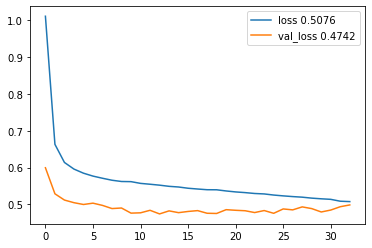

In [20]:
args = [8, 8, 16, 16], [16]
model = train_model(*args)
model.save('model_%s.hdf' % str(args))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 41, 41, 8)    0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 39, 39, 8)    584         max_pooling2d_13[0][0]           
____________________________________________________________________________________________

Epoch 13/500
30592/30592 [==============================] - 7s 244us/sample - loss: 0.5492 - action_move_loss: 0.2495 - action_rotate_loss: 0.2997 - action_move_acc: 0.9026 - action_rotate_acc: 0.8946 - val_loss: 0.4770 - val_action_move_loss: 0.2187 - val_action_rotate_loss: 0.2581 - val_action_move_acc: 0.9214 - val_action_rotate_acc: 0.9137
Epoch 14/500
30592/30592 [==============================] - 7s 238us/sample - loss: 0.5455 - action_move_loss: 0.2479 - action_rotate_loss: 0.2975 - action_move_acc: 0.9032 - action_rotate_acc: 0.8961 - val_loss: 0.4742 - val_action_move_loss: 0.2179 - val_action_rotate_loss: 0.2562 - val_action_move_acc: 0.9200 - val_action_rotate_acc: 0.9136
Epoch 15/500
30592/30592 [==============================] - 7s 243us/sample - loss: 0.5441 - action_move_loss: 0.2472 - action_rotate_loss: 0.2969 - action_move_acc: 0.9045 - action_rotate_acc: 0.8966 - val_loss: 0.4770 - val_action_move_loss: 0.2173 - val_action_rotate_loss: 0.2595 - val_action_move_acc: 0

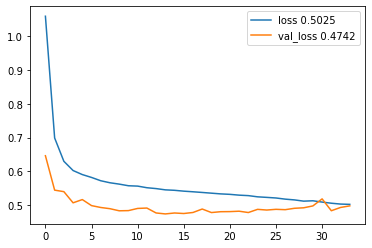

In [33]:
args = [8, 8, 16, 16, 32], [16]
model = train_model(*args)
model.save('/media/guillermo/Data/Kaggle/animalai/agents/003_less_games/model_%s.hdf' % str(args))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 41, 41, 8)    0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 39, 39, 16)   1168        max_pooling2d_17[0][0]           
____________________________________________________________________________________________

Epoch 13/500
30592/30592 [==============================] - 7s 242us/sample - loss: 0.5115 - action_move_loss: 0.2323 - action_rotate_loss: 0.2792 - action_move_acc: 0.9094 - action_rotate_acc: 0.9025 - val_loss: 0.4820 - val_action_move_loss: 0.2199 - val_action_rotate_loss: 0.2619 - val_action_move_acc: 0.9177 - val_action_rotate_acc: 0.9104
Epoch 14/500
30592/30592 [==============================] - 7s 245us/sample - loss: 0.5011 - action_move_loss: 0.2280 - action_rotate_loss: 0.2731 - action_move_acc: 0.9102 - action_rotate_acc: 0.9036 - val_loss: 0.4981 - val_action_move_loss: 0.2286 - val_action_rotate_loss: 0.2693 - val_action_move_acc: 0.9143 - val_action_rotate_acc: 0.9112
Epoch 15/500
30592/30592 [==============================] - 8s 252us/sample - loss: 0.4903 - action_move_loss: 0.2232 - action_rotate_loss: 0.2671 - action_move_acc: 0.9118 - action_rotate_acc: 0.9057 - val_loss: 0.5310 - val_action_move_loss: 0.2455 - val_action_rotate_loss: 0.2852 - val_action_move_acc: 0

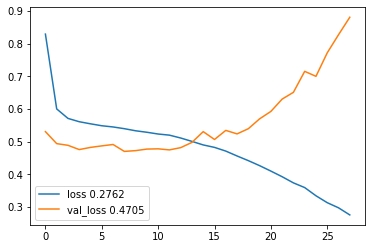

In [34]:
args = [8, 16, 32, 64, 128], [16]
model = train_model(*args)
model.save('/media/guillermo/Data/Kaggle/animalai/agents/003_less_games/model_%s.hdf' % str(args))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 41, 41, 8)    0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 39, 39, 16)   1168        max_pooling2d_21[0][0]           
____________________________________________________________________________________________

30592/30592 [==============================] - 8s 252us/sample - loss: 0.5451 - action_move_loss: 0.2463 - action_rotate_loss: 0.2988 - action_move_acc: 0.9037 - action_rotate_acc: 0.8939 - val_loss: 0.4703 - val_action_move_loss: 0.2126 - val_action_rotate_loss: 0.2574 - val_action_move_acc: 0.9230 - val_action_rotate_acc: 0.9145
Epoch 13/500
30592/30592 [==============================] - 8s 252us/sample - loss: 0.5429 - action_move_loss: 0.2454 - action_rotate_loss: 0.2975 - action_move_acc: 0.9036 - action_rotate_acc: 0.8940 - val_loss: 0.4807 - val_action_move_loss: 0.2193 - val_action_rotate_loss: 0.2614 - val_action_move_acc: 0.9223 - val_action_rotate_acc: 0.9110
Epoch 14/500
30592/30592 [==============================] - 8s 250us/sample - loss: 0.5394 - action_move_loss: 0.2436 - action_rotate_loss: 0.2958 - action_move_acc: 0.9052 - action_rotate_acc: 0.8952 - val_loss: 0.4711 - val_action_move_loss: 0.2131 - val_action_rotate_loss: 0.2578 - val_action_move_acc: 0.9238 - val_a

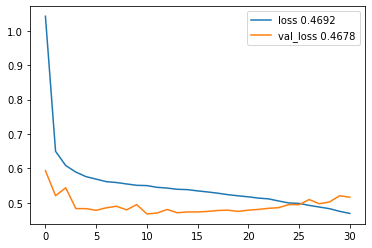

In [35]:
args = [8, 16, 32, 64, 64], [16, 16]
model = train_model(*args)
model.save('/media/guillermo/Data/Kaggle/animalai/agents/003_less_games/model_%s.hdf' % str(args))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 41, 41, 8)    0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 39, 39, 16)   1168        max_pooling2d_25[0][0]           
____________________________________________________________________________________________

30592/30592 [==============================] - 7s 245us/sample - loss: 0.5297 - action_move_loss: 0.2408 - action_rotate_loss: 0.2890 - action_move_acc: 0.9061 - action_rotate_acc: 0.8989 - val_loss: 0.5022 - val_action_move_loss: 0.2303 - val_action_rotate_loss: 0.2715 - val_action_move_acc: 0.9139 - val_action_rotate_acc: 0.9084
Epoch 13/500
30592/30592 [==============================] - 8s 248us/sample - loss: 0.5254 - action_move_loss: 0.2388 - action_rotate_loss: 0.2866 - action_move_acc: 0.9069 - action_rotate_acc: 0.8991 - val_loss: 0.4700 - val_action_move_loss: 0.2127 - val_action_rotate_loss: 0.2573 - val_action_move_acc: 0.9230 - val_action_rotate_acc: 0.9157
Epoch 14/500
30592/30592 [==============================] - 7s 245us/sample - loss: 0.5185 - action_move_loss: 0.2357 - action_rotate_loss: 0.2828 - action_move_acc: 0.9081 - action_rotate_acc: 0.9021 - val_loss: 0.5020 - val_action_move_loss: 0.2295 - val_action_rotate_loss: 0.2723 - val_action_move_acc: 0.9187 - val_a

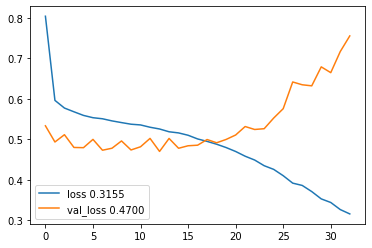

In [36]:
args = [8, 16, 32, 64, 64], [32, 32]
model = train_model(*args)
model.save('/media/guillermo/Data/Kaggle/animalai/agents/003_less_games/model_%s.hdf' % str(args))

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
frame (InputLayer)              [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 82, 82, 8)    224         frame[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 41, 41, 8)    0           conv2d_35[0][0]                  
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 39, 39, 16)   1168        max_pooling2d_29[0][0]           
____________________________________________________________________________________________

30592/30592 [==============================] - 8s 249us/sample - loss: 0.5309 - action_move_loss: 0.2408 - action_rotate_loss: 0.2900 - action_move_acc: 0.9057 - action_rotate_acc: 0.8975 - val_loss: 0.4888 - val_action_move_loss: 0.2222 - val_action_rotate_loss: 0.2663 - val_action_move_acc: 0.9182 - val_action_rotate_acc: 0.9075
Epoch 13/500
30592/30592 [==============================] - 8s 254us/sample - loss: 0.5273 - action_move_loss: 0.2393 - action_rotate_loss: 0.2881 - action_move_acc: 0.9062 - action_rotate_acc: 0.8983 - val_loss: 0.4717 - val_action_move_loss: 0.2151 - val_action_rotate_loss: 0.2565 - val_action_move_acc: 0.9225 - val_action_rotate_acc: 0.9149
Epoch 14/500
30592/30592 [==============================] - 8s 260us/sample - loss: 0.5221 - action_move_loss: 0.2371 - action_rotate_loss: 0.2849 - action_move_acc: 0.9084 - action_rotate_acc: 0.9013 - val_loss: 0.4757 - val_action_move_loss: 0.2169 - val_action_rotate_loss: 0.2587 - val_action_move_acc: 0.9204 - val_a

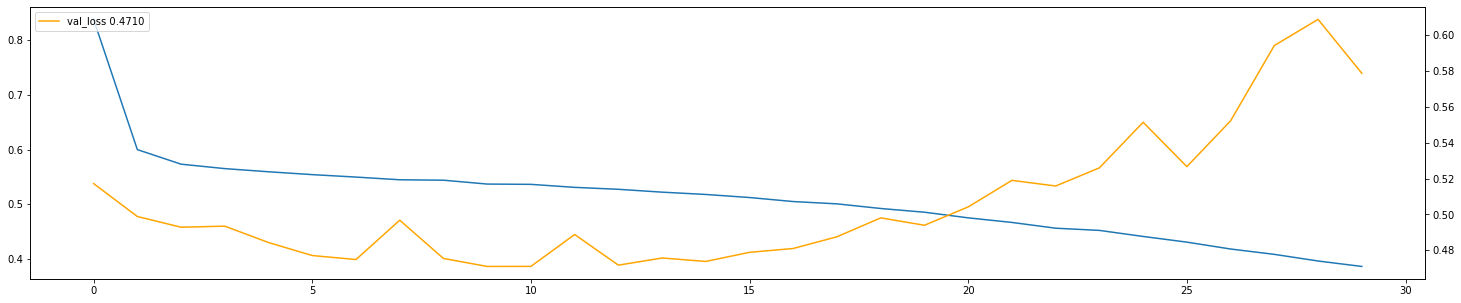

In [41]:
args = [8, 16, 32, 64, 64], [16, 32]
model = train_model(*args)
model.save('/media/guillermo/Data/Kaggle/animalai/agents/003_less_games/model_%s.hdf' % str(args))

#### Summary of trainings

There is no big differen between models.

In [75]:
raise

RuntimeError: No active exception to reraise

## Visualizing agent play

In [50]:
model = load_model('/media/guillermo/Data/Kaggle/animalai/agents/003_less_games/model_([8, 16, 32, 64, 64], [16, 16]).hdf')

W0719 19:51:19.642918 140311670503232 deprecation.py:506] From /home/guillermo/miniconda3/envs/animal/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0719 19:51:19.644972 140311670503232 deprecation.py:506] From /home/guillermo/miniconda3/envs/animal/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [42]:
class Agent():
    def __init__(self, model):
        self._n_rotations = 0
        self.model = model

    def get_action_from_model(self, info):
        frame = info.visual_observations[0][0]
        speed = info.vector_observations.round(2)
        previous_action = info.previous_vector_actions[0]

        model_input = {
            'frame': np.expand_dims(frame, axis=0),
            'speed': speed/10,
        }
        previous_move, previous_rotate = np.zeros(3), np.zeros(3)
        previous_move[int(previous_action[0])] = 1
        previous_rotate[int(previous_action[1])] = 1
        previous_action = np.concatenate([previous_move, previous_rotate])
        model_input['previous_action'] = np.expand_dims(previous_action, axis=0)
        ret = self.model.predict(model_input, batch_size=1)
        action_move = ret[self.model.output_names.index('action_move')]
        action_rotate = ret[self.model.output_names.index('action_rotate')]
        action = [np.argmax(action_move), np.argmax(action_rotate)]
        if action == [0, 0]:
            action = [1, 0]
        if action[0] == 0:
            self._n_rotations += 1
        else:
            self._n_rotations = 0
        if self._n_rotations > 60:
            action = [1, 0]
        return action
    
    def reset(self):
        self._n_rotations = 0

In [51]:
info = env.reset()['Learner']
level_idx = 0
n_steps = 0
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
agent = Agent(model)

while 1:
    frame = info.visual_observations[0][0]
    speed = info.vector_observations.round(2)
    previous_action = info.previous_vector_actions[0]
    
    cv2.imshow('img', frame[:, :, [2, 1, 0]])
    msg = 'Level: %i     n_steps: %i   Reward: %.2f   Speed: %s Text observations: %s' % (
        level_idx,
        n_steps,
        info.rewards[0],
        speed,
        info.text_observations[0])
    cv2.displayOverlay('img', msg)
    key = cv2.waitKey(1)
    if key == ord('o'):
        break
    action = agent.get_action_from_model(info)
    
    info = env.step(vector_action=action)['Learner']
    n_steps += 1
    is_level_ended = info.max_reached[0] or info.local_done[0]
    if is_level_ended:
        level_idx += 1
        n_steps = 0
        agent.reset()
        
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

I think that collection of goals has worsened, hopefully it will improve in other categories.

## Summary